In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as stats
import statsmodels.tsa.stattools as stattools

#### Trading mechanism

In a Perpetual Futures market, traders are periodically awarded or penalized by a 'funding rate' based on whether their entry positions are above or below the price of the asset in the spot market at the time of funding (which occurs periodically), and whether they are long or short the position. 

For example, a trader who is long BTC at `$`40,000 will receive the funding rate if the spot price is `$`42,000 at the time of funding. A trader who is short (indeed, the trader who took the opposite side of the long position) will have to pay the same funding rate to the exchange. Since every long position is matched with a short position, the traders are basically paying each other each period, provided they have balances in their accounts. 

Since the funding depends on the spot price data provided exogneously to the perpetual market, to create our simulation, we first need a data-generating process that creates these spot prices.

#### External price data for simulation

We will first simulate this external 'spot' price using a Geometric Brownian Motion (GBM) data-generating process. This is the most commonly used model for simulating stock prices \<will include citation source\>. 

A GBM is a stochastic process governed by the following equation:

$ S_t = S_0 e^{((\mu - \frac{\sigma}{2}) + \sigma W_t )}$

Where:

$t$ : time 

$S_t$ : the price at time $t$

$S_0$ : the price at $t = 0$

$\mu$ : a 'drift' variable representing the trend of the price movement

$\sigma$ : the volatility or variation of the prices (standard deviation). In this formulation, the volatility is constant, which is not very realistic. This will be addressed later.

$W_t$ : a 'weiner process' representing the unpredictability of the prices (here a random walk)

##### Sample Code:

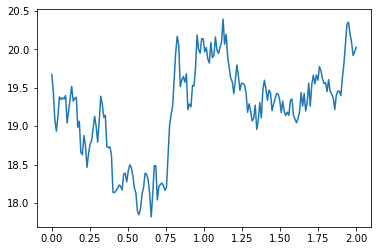

In [3]:
# Time horizon over which the data will be generated. Can be understood as any period we so choose
Time_horizon = 2

mu = 0.01
sigma = 0.1
S0 = 20
# Time interval for each server tick
dt = 0.01

# Number of server ticks in given time period
N = round(Time_horizon/dt)

# Generate the server ticks as a vector of length N, with interval dt (linspace splits T N times, starting at 0 here)
t = np.linspace(0, Time_horizon, N)

# Generate weiner process 
# Draw N values from normal distribution for increment/decrement at each server tick, 
W = np.random.standard_normal(size = N) 
# then sum them cumulatively and scale by sqrt of dt to get random walk
W = np.cumsum(W)*np.sqrt(dt) 

# Generate GBM using formula
S = S0*np.exp((mu-0.5*sigma**2)*t + sigma*W)

# Plot
plt.plot(t, S)
plt.show()

#### Agents

The traders in this simulation are based on this paper: Carl Chiarella and Giulia Iori. A simulation analysis of the microstructure of double auction markets. Quantitative Finance, 2:346–353, 2002. 

This is a seminal paper that particularly models [Limit Order Book](https://en.wikipedia.org/wiki/Central_limit_order_book)-based exchanges simply.

In this paper, each trader is modelled as a composite of the following types of traders:

- Fundamentalist traders who believe the prices are mean reverting to a 'true price'
- Chartists who use local trends to forecast prices
- Noise traders who place trades randomly

Our model will be based on code by Blake LeBaron from the [agentfin](http://people.brandeis.edu/~blebaron/classes/agentfin/Chiarellaetal.html) website.

##### Sample Agent Code:

In [8]:
class agent:
    
    # Agent constructor
    def __init__(self,sigmaF,sigmaM,sigmaN,kmax,Lmin,Lmax):
        self.position = (null, null)
        # set strategy weights randomly
        # Fundamentalist weight is always positive
        self.fundWeight =  np.abs(sigmaF*np.random.randn())
        self.chartWeight = (sigmaM*np.random.randn())
        self.noiseWeight = (sigmaN*np.random.randn())
        # random horizon for momentum rules 
        self.l = np.random.randint(Lmin,Lmax)
        # random component of spread
        self.k = kmax*np.random.rand()
        # Initialize forecasts
        self.fcast = 0.
        self.pfcast = 0.
        self.wealth = 0.
        self.bid = 0.
        self.ask = 0.
        # forecast adjustment weight
        self.fcastAdjust = 1./(self.fundWeight+self.chartWeight+self.noiseWeight)
    
    # Function that forecasts the price for the next tick.
    def updateFcast(self,forecast,price,tau):
        # weighted forecast value
        self.fcast = self.fcastAdjust*(self.fundWeight*forecast.fundamental+self.chartWeight*forecast.chartist[self.l] + self.noiseWeight*forecast.noise)
        # bound the forecast
        self.fcast = min(self.fcast,0.5)
        self.fcast = max(self.fcast,-0.5)
        # exponentiate the forecast to get future price forecast 
        # note:  this could have a variance adjustment, but it doesn't at the moment
        self.pfcast = price*np.exp(self.fcast+0.0*forecast.v)
        
    def getAgentOrder(self,price):
        # generate bid or ask with k and forecast price
        if self.pfcast > price:
            self.bid = (1.-self.k)*self.pfcast
        else :
            self.ask = (1.+self.k)*self.pfcast

This code only instantiates the agents with a distribution of the weights each trader applies to a trading 'approach', and provides funcions that updates their price forecasts and orders. The actual forecast logic will be detailed below. 

##### Agent instantiation and distribution

In [4]:
# Set number of agents
nAgents = 500
# Default weights for 
# Fundamentalist weight
sigmaF = 1.
# Chartist weight
sigmaM = 1.
# Noise weight
sigmaN = 1.
# horizons for momentum rules - bounds for how far back should they go to estimate trend
Lmin = 5
Lmax = 50
# random component of spread
kMax = 0.5

# holder list for agent objects
agentList = []
for i in range(nAgents):
    agentList.append(agent(sigmaF,sigmaM,sigmaN,kMax,Lmin,Lmax))

fundWeightList = [a.fundWeight for a in agentList]
chartWeightList = [a.chartWeight for a in agentList]
noiseWeightList = [a.noiseWeight for a in agentList]

The agent population thus created has a distribution across the various strategies, with fundamentalist always having a positive weight, whilst chartists and noise traders can be negative as well as positively weighted. This functionality allows us to control the characteristics of the trading population with regard to these trading strategies. The distribution is visualized below, with fundamentalist weights on the x-axis, chartist weights on the y-axis and noise trader weights on the z-axis:

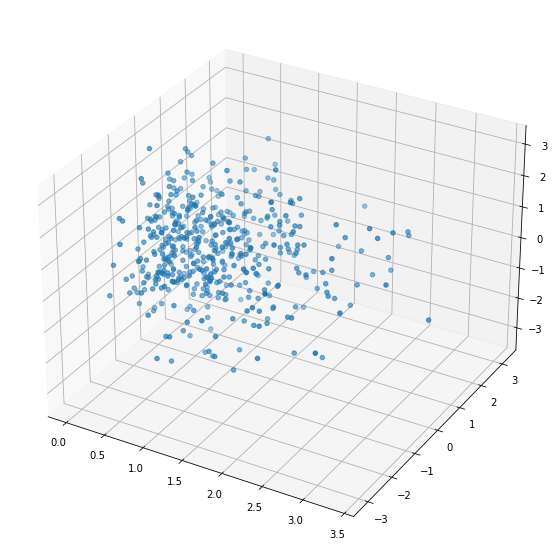

In [5]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(fundWeightList, chartWeightList, noiseWeightList)

##### Price Forecasts

To better understand how agents make trading decisions, let us look at the code for forecast generation. While the original code for traditional stock markets updates the price forecast for the next server tick, the code below updates the price forecast for the *next funding period* which can be many server ticks ahead of the current tick. 

In [6]:
class forecasts:
    # initialize forecast components
    def __init__(self,Lmax,pf,sigmae):
        self.fundamental = 0.
        # chartist is vector for different lengths
        self.chartist = np.zeros(Lmax)
        self.noise = 0.
        self.v = 0.
        self.pf = pf
        self.sigmae = sigmae
        self.Lmax = Lmax

    # update forecasts   
    def updateForecasts(self,t,price,ret,extPrice,extRet,next_funding_t):
        # Variance of returns
        self.v = np.var(ret[0:t])
        
        # The Fundamentalist believes the price reverts to the mean
        self.fundamental = (mean(extPrice) - price)/price
        
        # The Chartist captures the moving average within a time horizon
        revrets = extRet[t:(t-self.Lmax):-1]
        self.chartist = np.cumsum(revrets)/np.arange(1.,float(self.Lmax+1))
        self.noise = self.sigmae*np.random.randn()

The updateForecasts 